<h1 align="center">Learning Rate Decay in TensorFlow</h1>

In [90]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import pandas as pd

This is an example of applying learning rate decay in TensorFlow, using Gradient Descent to solve a simple Linear Regression.

First we set up some test data:

In [91]:
X_df = pd.DataFrame(np.random.rand(100, 3))
w_actual = pd.Series(data=[2, 3, 5])
y_true = X_df.dot(w_actual)

# add a small noise to y
y_true += np.random.normal(scale=1E-6, size=100)

Now we're ready to set up the TensorFlow solution:

In [92]:
import tensorflow as tf

First we define placeholders and a weights vector that we'll learn from the data.

In [93]:
tf.reset_default_graph()

X = tf.placeholder(shape=X_df.shape, dtype=tf.float32, name='X')
y = tf.placeholder(shape=[len(y_true), 1], dtype=tf.float32, name='y')
w = tf.get_variable(
    'coeff', 
    initializer=tf.truncated_normal_initializer(dtype=tf.float32), shape=[3, 1] 
)

Then we use calculate the MSE between the prediction $w^TX$ and the actual y and use a GradientDescentOptimizer to minimize the loss using a staircased learning rate.

In [94]:
y_pred = tf.matmul(X, w)
loss = tf.losses.mean_squared_error(y_pred, y)

starter_learning_rate = 0.08

learning_rate = tf.train.exponential_decay(
    learning_rate=starter_learning_rate,
    global_step=tf.train.get_or_create_global_step(),
    decay_steps=10,
    decay_rate=0.8,
    staircase=True, 
    name='learning_rate')

train_op = tf.train.GradientDescentOptimizer(
    learning_rate=learning_rate).minimize(loss, global_step=tf.train.get_global_step())

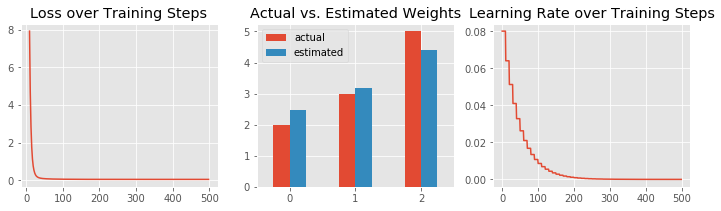

In [95]:
losses = []
learning_rates = []

input_data = {
    X: X_df.values, 
    y: y_true.values.reshape([100, 1])
}

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    for i in range(1, 500):
        _, loss_val, lr = sess.run([train_op, loss, learning_rate], feed_dict=input_data)
        losses.append(loss_val)
        learning_rates.append(lr)

    w_estimated = sess.run(w).squeeze()

_, ax = plt.subplots(1, 3, figsize=(12, 3))

losses = pd.Series(losses)
_ = losses.rolling(10).mean().plot(title='Loss over Training Steps', ax=ax[0])

w_df = pd.DataFrame.from_records(
    [w_actual.values, w_estimated], 
    index=['actual', 'estimated']).T

_ = w_df.plot(kind='bar', rot=0, ax=ax[1], title='Actual vs. Estimated Weights')

learning_rates = pd.Series(learning_rates)
_ = learning_rates.plot(ax=ax[2], title='Learning Rate over Training Steps')